In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.options.display.max_columns=1000
mlp.rcParams["figure.dpi"] = 200
mlp.rcParams["figure.facecolor"] = "white"

In [23]:
its = pd.read_csv("../../../../Outcome Measurement Data/HIV/SIGPRO/sigpro_f4_JanNov2018 - ITS.csv")
vinculacion = pd.read_csv("../../../../Outcome Measurement Data/HIV/SIGPRO/sigpro_f4_JanNov2018 - Vinculacion.csv")

In [24]:
pb_tvc = pd.read_csv("../../../../Outcome Measurement Data/HIV/SIGPRO/sigpro_f4_JanNov2018 - PB_TVC.csv")

In [4]:
ejecutores = {
    "NAC0401": "CAS",
    "NAC0402": "OTRANS",
    "NAC0403": "FUNDACION MARCO ANTONIO", 
    "NAC0404": "ASOCIACION IDEI",
    "NAC0405": "FUNDACION FERNANCO ITURBIDE",
    "NAC0101": "HIVOS"
}


In [5]:
pb_tvc["Ejecutores"] = pb_tvc.codejecutor.replace(ejecutores)
its["Ejecutores"] = its.codejecutor.replace(ejecutores)
pb_tvc["Mes"] = pb_tvc.fechareal.apply(lambda x: str(x)[0:7])
pb_tvc["Mes2"] = pb_tvc.codanno * 12 + pb_tvc.codmes
pb_tvc.columns

Index(['Unnamed: 0', 'numeroInforme', 'codigoActividad', 'codigounico',
       'codgrupo', 'codsubgrupo', 'refervih', 'prePruebaVIH', 'pruebaVIH',
       'postPruebaVIH', 'conoceResultadoVIH', 'codResultadoVIH',
       'conoceResultadoSif', 'codResultadoSif', 'condonesMasculinos',
       'condonesFemeninos', 'condonesSabores', 'lubriSachet', 'lubriTubo',
       'impresos', 'grupo', 'subgrupo', 'resultadoVIH', 'codejecutor',
       'codanno', 'codmes', 'codigoTipoActividad', 'tipoActividad',
       'resultadoSif', 'codDepMun', 'lugar', 'direccion', 'responsable',
       'educador', 'unmovil', 'fechareal', 'departamento', 'municipio', 'tema',
       'pqBasico', 'Date', 'Gender', 'Age', 'municode', 'Ejecutores', 'Mes',
       'Mes2'],
      dtype='object')

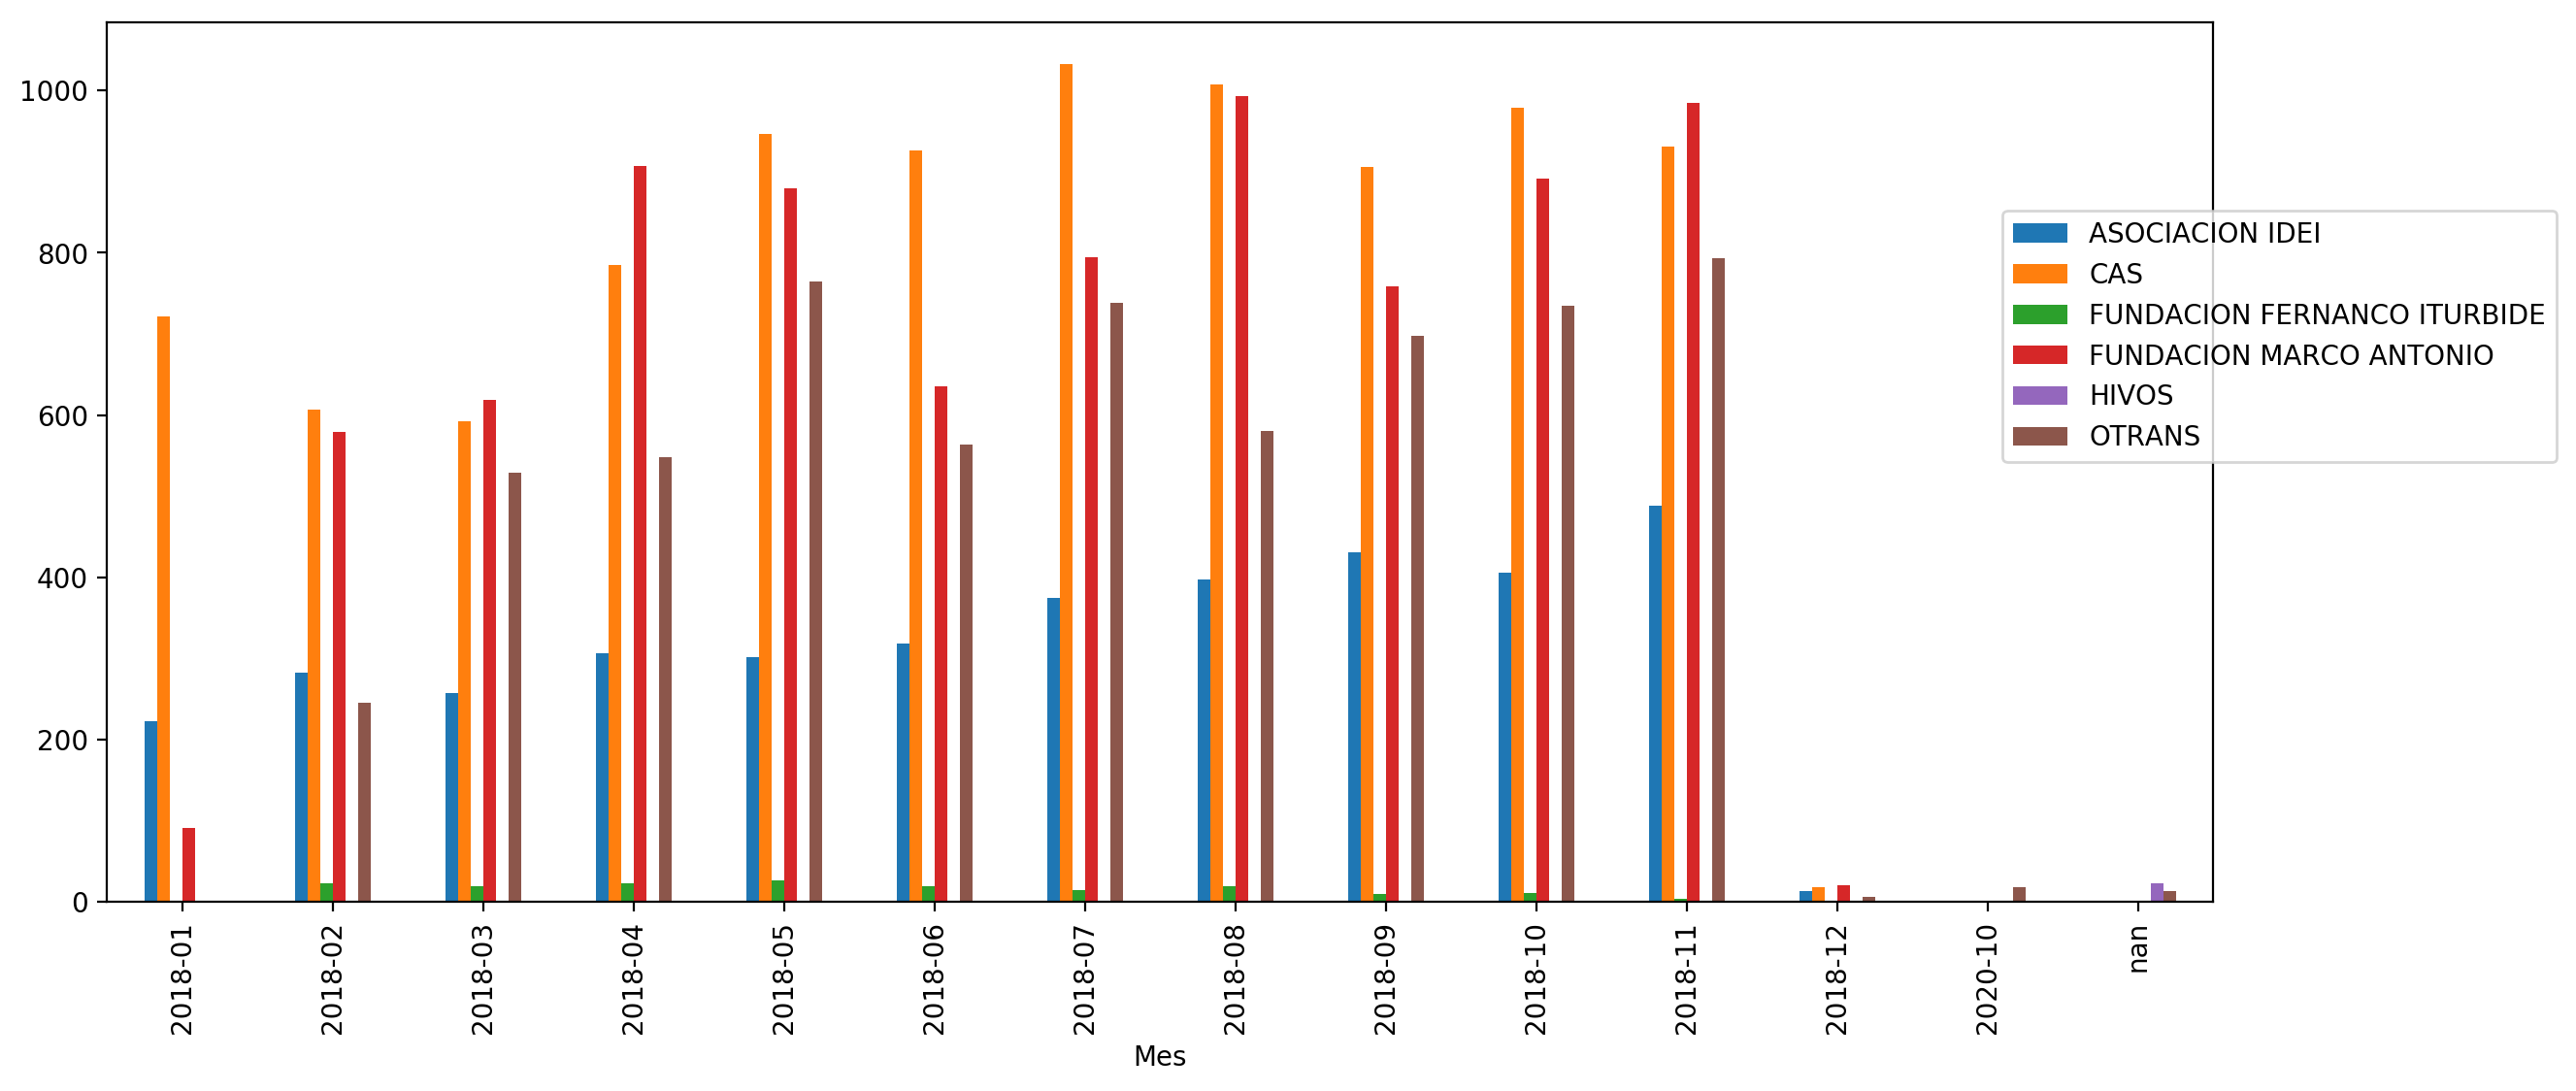

In [6]:
plt.rcParams["figure.figsize"] = (14,6)
temp = pb_tvc[pb_tvc.Mes != "NaT"].groupby(["Ejecutores", "Mes"]).numeroInforme.count()
temp.unstack(0).plot.bar()
plt.legend(loc=(0.9,0.5))

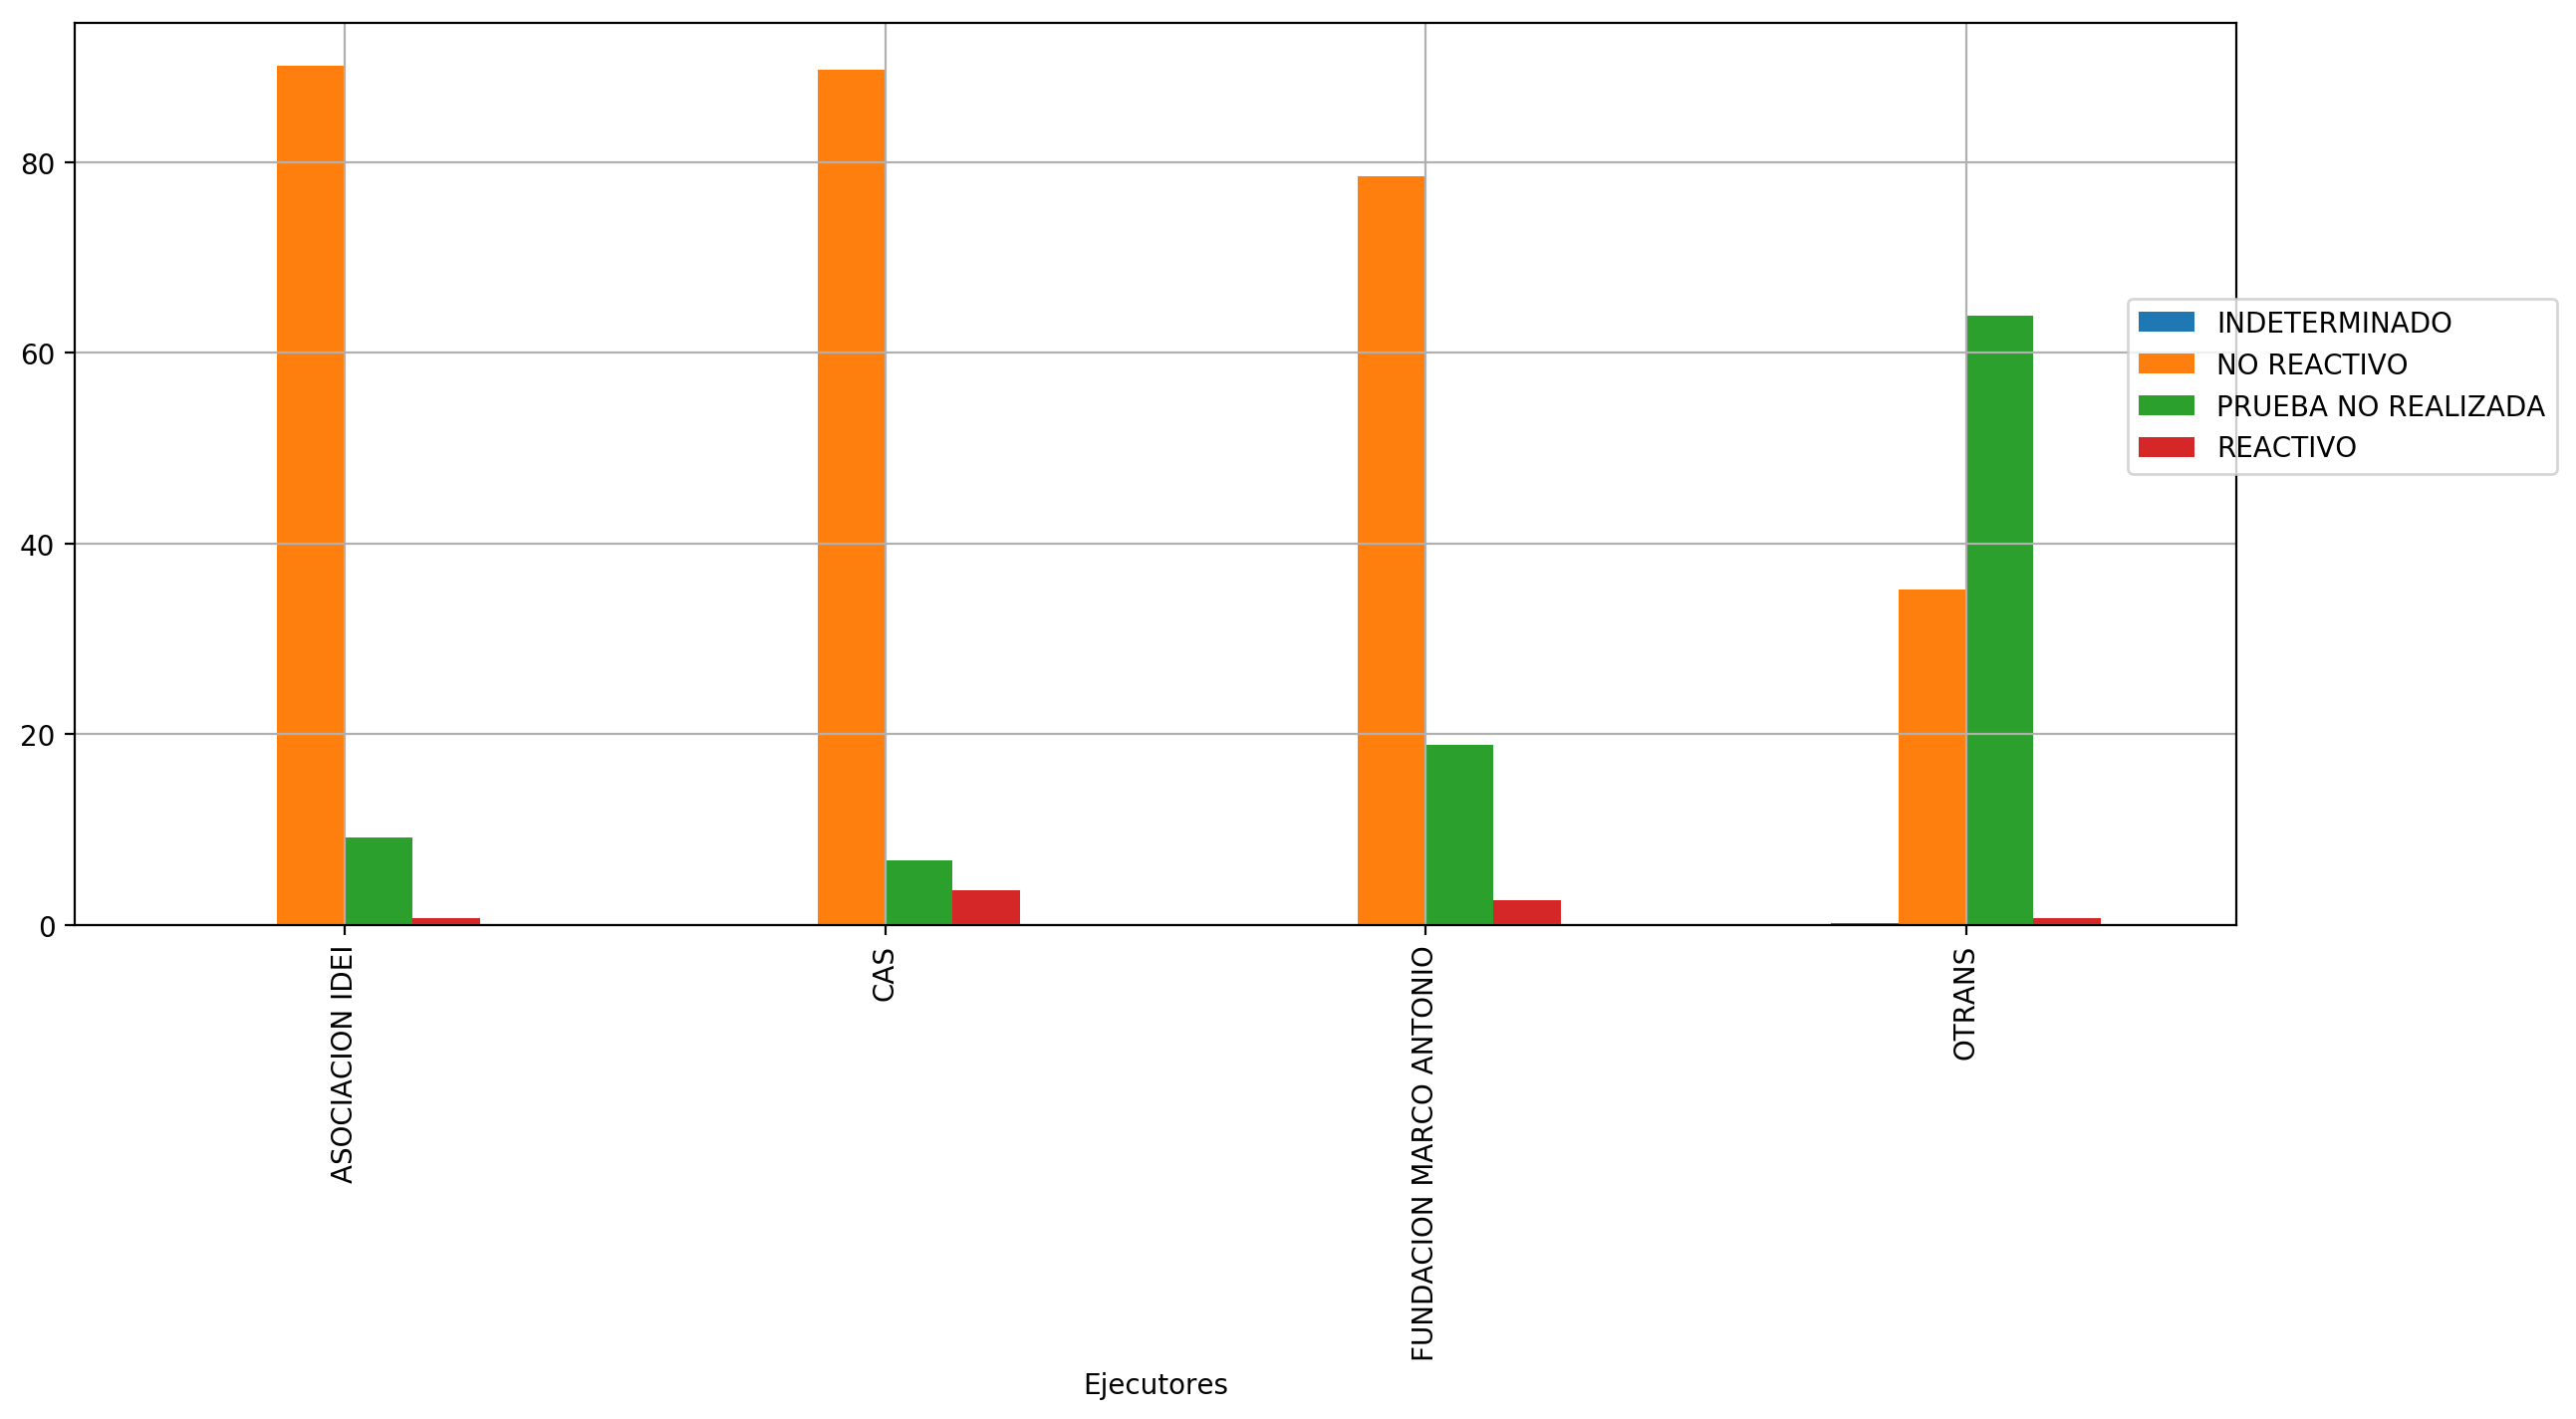

In [7]:
plt.rcParams["figure.figsize"] = (14,6)
temp = pb_tvc[(pb_tvc.Mes != "NaT") & (pb_tvc.Ejecutores.isin(["FUNDACION FERNANCO ITURBIDE", "HIVOS"])==False)]\
        .groupby(["Ejecutores", "resultadoVIH"]).numeroInforme\
        .count().unstack(1).fillna(0)
temp["total"] = temp.sum(axis=1)
temp2 = temp.divide(temp.total, axis = 0)*100
temp2[temp2.columns.tolist()[0:-1]].plot.bar()
plt.legend(loc=(0.95,0.5))
plt.grid()

In [8]:
plt.rcParams["figure.figsize"] = (5,10)
temp = pb_tvc[(pb_tvc.Mes != "NaT") ]\
        .groupby(["subgrupo", "resultadoVIH"]).numeroInforme\
        .count().unstack(1).fillna(0)
temp["total"] = temp.sum(axis=1)
temp2 = temp.divide(temp.total, axis = 0)*100
temp2

resultadoVIH,INDETERMINADO,NO REACTIVO,PRUEBA NO REALIZADA,REACTIVO,total
subgrupo,,,,,
HSH ADOLESCENTES Y JOVENES,0.00000,94.713656,1.321586,3.964758,100.0
HSH MAYORES DE 18 AÃ‘OS,0.00000,86.379010,10.843497,2.777493,100.0
PV ABORDADA EN OTROS LUGARES,0.00000,100.000000,0.000000,0.000000,100.0
PV ABORDADA EN UAI,0.00000,100.000000,0.000000,0.000000,100.0
TRANS ADOLESCENTES Y JOVENES,0.00000,100.000000,0.000000,0.000000,100.0
TRANS DE DIFERENTES PUEBLOS,0.00000,67.021277,28.191489,4.787234,100.0
TRANS MAYORES DE 18 AÃ‘OS,0.18521,43.220003,55.695198,0.899590,100.0
TRANS MIGRANTES,0.00000,0.000000,100.000000,0.000000,100.0
TRANS TRABAJADORAS SEXUALES,0.00000,29.885057,70.114943,0.000000,100.0


In [ ]:
# 'Tis not a good idea to merge
# merged = pb_tvc.merge(its, on = "codigounico", suffixes = ("", "_its"), how = "outer")\
#        .merge(vinculacion, on = "codigounico", suffixes = ("", "_vinc"), how = "outer")


In [10]:
def process(data):
    return pd.Series(data = [
        len(data), 
        (data.numeroInforme_its.isna()==False).sum(),
        (data.resultadoVIH == "REACTIVO").sum(),
        (data.numeroInforme_vinc.isna()==False).sum()
    ], index=["PB/TVC", "ITS", "VIH Reactivo", "Vinculación"])
temp = merged[merged.subgrupo.apply(lambda x: x.startswith("PV ")==False if type(x) == str else True)]\
        .groupby("subgrupo").apply(process).fillna(0)
#temp["total"] = temp.sum(axis=1)
temp2 = temp.divide(temp["PB/TVC"], axis = 0) * 100
#temp.loc["total"] = temp.sum(axis=0)
print(temp2.round(2))
temp.loc["total"] = temp.sum(axis=0)
print("\n\n")
print(temp.divide(temp.loc["total"], axis = 1).round(4)*100)
print("\n\n")
temp3 = temp[["PB/TVC", "VIH Reactivo", "Vinculación"]].copy()
temp3["VIH Reactivo"] = temp3["VIH Reactivo"]/temp3["PB/TVC"]
temp3["Vinculación"] = temp3["Vinculación"]/temp3["PB/TVC"]/temp3["VIH Reactivo"]

temp3.round(3).fillna(0)*100
    #print(temp.divide(temp.loc["total"], axis = 1).round(4)*100)

                              PB/TVC    ITS  VIH Reactivo  Vinculación
subgrupo                                                              
HSH ADOLESCENTES Y JOVENES     100.0  53.75          6.25         3.75
HSH MAYORES DE 18 AÃ‘OS        100.0  43.56          3.03         2.03
TRANS ADOLESCENTES Y JOVENES   100.0   0.00          0.00         0.00
TRANS DE DIFERENTES PUEBLOS    100.0   9.89          7.14         4.95
TRANS MAYORES DE 18 AÃ‘OS      100.0   9.78          1.52         0.91
TRANS MIGRANTES                100.0   0.00          0.00         0.00
TRANS TRABAJADORAS SEXUALES    100.0   8.70          0.00         0.00



                              PB/TVC     ITS  VIH Reactivo  Vinculación
subgrupo                                                               
HSH ADOLESCENTES Y JOVENES      0.57    0.86          1.29         1.17
HSH MAYORES DE 18 AÃ‘OS        74.71   92.29         82.47        83.59
TRANS ADOLESCENTES Y JOVENES    0.02    0.00          0.00         0.0

,PB/TVC,VIH Reactivo,Vinculación
subgrupo,,,
HSH ADOLESCENTES Y JOVENES,8000,6.2,60.0
HSH MAYORES DE 18 AÃ‘OS,1055200,3.0,66.9
TRANS ADOLESCENTES Y JOVENES,300,0.0,0.0
TRANS DE DIFERENTES PUEBLOS,18200,7.1,69.2
TRANS MAYORES DE 18 AÃ‘OS,328300,1.5,60.0
TRANS MIGRANTES,100,0.0,0.0
TRANS TRABAJADORAS SEXUALES,2300,0.0,0.0
total,1412400,2.7,66.0


In [15]:
merged.groupby(["Ejecutores", "subgrupo"]).apply(process).fillna(0).reset_index()

,Ejecutores,subgrupo,PB/TVC,ITS,VIH Reactivo,Vinculación
0,ASOCIACION IDEI,HSH ADOLESCENTES Y JOVENES,4,0,0,0
1,ASOCIACION IDEI,HSH MAYORES DE 18 AÃ‘OS,1481,354,14,11
2,ASOCIACION IDEI,TRANS MAYORES DE 18 AÃ‘OS,357,65,4,0
3,ASOCIACION IDEI,TRANS TRABAJADORAS SEXUALES,3,0,0,0
4,CAS,HSH ADOLESCENTES Y JOVENES,76,43,5,3
5,CAS,HSH MAYORES DE 18 AÃ‘OS,5360,3774,202,136
6,FUNDACION FERNANCO ITURBIDE,PV ABORDADA EN OTROS LUGARES,112,0,0,0
7,FUNDACION FERNANCO ITURBIDE,PV ABORDADA EN UAI,1,0,0,0
8,FUNDACION MARCO ANTONIO,HSH MAYORES DE 18 AÃ‘OS,3710,468,104,67
9,FUNDACION MARCO ANTONIO,TRANS DE DIFERENTES PUEBLOS,181,18,13,9


In [6]:
pb_tvc.groupby(["codigounico", "grupo", "Ejecutores"]).codigounico.count().rename("value")\
.reset_index().groupby(["grupo", "Ejecutores"]).value.value_counts()\
.unstack(1,fill_value=0)

Ejecutores   ASOCIACION IDEI   CAS  FUNDACION FERNANCO ITURBIDE  \
grupo value                                                       
HSH   1                 1292  3356                            0   
      2                   47   479                            0   
      3                    4    49                            0   
      4                    1    15                            0   
      5                    0     3                            0   
      7                    0     0                            0   
      17                   0     0                            0   
      86                   0     1                            0   
PV    1                    0     0                          103   
      2                    0     0                            5   
TRANS 1                  337     0                            0   
      2                    3     0                            0   
      3                    1     0                            0   
      4                    0     0                            0   
      5                    1     0                            0   
      6                    0     0                            0   
      7                    0     0                            0   

Ejecutores   FUNDACION MARCO ANTONIO  HIVOS  OTRANS  
grupo value                                          
HSH   1                         3051      1       0  
      2                          230      0       0  
      3                           20      0       0  
      4                            5      0       0  
      5                            1      0       0  
      7                            1      0       0  
      17                           1      0       0  
      86                           0      0       0  
PV    1                            0      0       0  
      2                            0      0       0  
TRANS 1                          237     22    2123  
      2                           32      0     151  
      3                           12      0      46  
      4                            5      0      14  
      5                            1      0       5  
      6                            0      0       5  
      7                            0      0       1

In [41]:
its.groupby(["codigounico", "subgrupo", "Ejecutores"]).codigounico.count().rename("value")\
.reset_index().groupby(["subgrupo", "Ejecutores"]).value.value_counts()\
.unstack(1,fill_value=0)

Ejecutores                          ASOCIACION IDEI   CAS  \
subgrupo                     value                          
HSH ADOLESCENTES Y JOVENES   1                    1    46   
                             2                    0     2   
HSH MAYORES DE 18 AÃ‘OS      1                  363  2473   
                             2                   38   314   
                             3                    8    32   
                             4                    3     3   
                             6                    1     0   
TRANS ADOLESCENTES Y JOVENES 1                    0     0   
TRANS DE DIFERENTES PUEBLOS  1                    0     0   
                             2                    0     0   
TRANS MAYORES DE 18 AÃ‘OS    1                   82     0   
                             2                    3     0   
                             3                    0     0   
                             6                    0     0   
TRANS TRABAJADORAS SEXUALES  1                    0     0   
                             2                    0     0   

Ejecutores                          FUNDACION MARCO ANTONIO  HIVOS  OTRANS  
subgrupo                     value                                          
HSH ADOLESCENTES Y JOVENES   1                            0      0       0  
                             2                            0      0       0  
HSH MAYORES DE 18 AÃ‘OS      1                          567      2       0  
                             2                           57      0       0  
                             3                            8      1       0  
                             4                            1      0       0  
                             6                            0      0       0  
TRANS ADOLESCENTES Y JOVENES 1                            0      0       2  
TRANS DE DIFERENTES PUEBLOS  1                           24      0       0  
                             2                            2      0       0  
TRANS MAYORES DE 18 AÃ‘OS    1                           37      0     205  
                             2                            0      0      13  
                             3                            0      0       4  
                             6                            0      0       1  
TRANS TRABAJADORAS SEXUALES  1                            0      0       9  
                             2                            0      0       1

In [7]:
def processGroup(df) : 
    if len(df)>1:
        return df.Mes2.sort_values().diff().value_counts(dropna=True)
x = pb_tvc.groupby(["codigounico", "grupo", "Ejecutores"]).apply(processGroup)#.value_counts(dropna=False)
#.codigounico.count().rename("value")\
#.reset_index().groupby(["grupo", "Ejecutores"]).value.value_counts()\
#.unstack(1,fill_value=0)

In [62]:
(x[x.isna()==False].unstack(3)[0]+1).reset_index().groupby("Ejecutores")[0].value_counts().unstack(0, fill_value=0)

,2.0,3.0,4.0,5.0,6.0,14.0,82.0
Ejecutores,,,,,,,
ASOCIACION IDEI,7,0,0,0,0,0,0
CAS,50,5,0,0,0,0,1
FUNDACION FERNANCO ITURBIDE,1,0,0,0,0,0,0
FUNDACION MARCO ANTONIO,30,3,0,1,0,1,0
OTRANS,67,12,4,1,1,0,0


In [56]:
pb_tvc.head()

,numeroInforme,codigoActividad,codigounico,codgrupo,codsubgrupo,refervih,prePruebaVIH,pruebaVIH,postPruebaVIH,conoceResultadoVIH,codResultadoVIH,conoceResultadoSif,codResultadoSif,condonesMasculinos,condonesFemeninos,condonesSabores,lubriSachet,lubriTubo,impresos,grupo,subgrupo,resultadoVIH,codejecutor,codanno,codmes,codigoTipoActividad,tipoActividad,resultadoSif,codDepMun,lugar,direccion,responsable,educador,unmovil,fechareal,departamento,municipio,tema,Ejecutores,Mes,Mes2
0,20180200003,140,F22078810501RACO00,4,16,N,N,N,N,N,1,N,1,48,0,0,48,0,0,PV,PV ABORDADA EN OTROS LUGARES,NO REACTIVO,NAC0405,2,2,10,VISITAS DOMICILIARES,NO REACTIVO,501,Casa de habitaciones PV,Casa de habitaciones PV,Estuardo Cabrera,Estuardo Cabrera,N,2018-02-21,Escuintla,Escuintla,VIH,FUNDACION FERNANCO ITURBIDE,2018-02,26
1,20180200003,141,M20027210501NARA00,4,16,N,N,N,N,N,1,N,1,48,0,0,48,0,0,PV,PV ABORDADA EN OTROS LUGARES,NO REACTIVO,NAC0405,2,2,10,VISITAS DOMICILIARES,NO REACTIVO,501,Casa de habitaciones PV,Casa de habitaciones PV,Estuardo Cabrera,Estuardo Cabrera,N,2018-02-22,Escuintla,Escuintla,VIH,FUNDACION FERNANCO ITURBIDE,2018-02,26
2,20180200003,2189,M10057610502CAMA00,4,16,N,N,N,N,N,1,N,1,48,0,0,48,0,0,PV,PV ABORDADA EN OTROS LUGARES,NO REACTIVO,NAC0405,2,2,10,VISITAS DOMICILIARES,NO REACTIVO,502,Casa de habitaciones PV,Casa de habitaciones PV,Estuardo Cabrera,Estuardo Cabrera,N,2018-02-28,Escuintla,Santa Lucia Cotzumalguapa,VIH,FUNDACION FERNANCO ITURBIDE,2018-02,26
3,20180200003,133,F26048011801ERGU00,4,16,N,N,N,N,N,1,N,1,48,0,0,48,0,0,PV,PV ABORDADA EN OTROS LUGARES,NO REACTIVO,NAC0405,2,2,10,VISITAS DOMICILIARES,NO REACTIVO,1801,Casa de habitaciones PV,Casa de habitaciones PV,Manuel Augusto Choc,Manuel Augusto Choc,N,2018-02-13,Izabal,Puerto Barrios,VIH,FUNDACION FERNANCO ITURBIDE,2018-02,26
4,20180200003,134,F16057511801JUBO00,4,16,N,N,N,N,N,1,N,1,48,0,0,48,0,0,PV,PV ABORDADA EN OTROS LUGARES,NO REACTIVO,NAC0405,2,2,10,VISITAS DOMICILIARES,NO REACTIVO,1801,Casa de habitaciones PV,Casa de habitaciones PV,Manuel Augusto Choc,Manuel Augusto Choc,N,2018-02-06,Izabal,Puerto Barrios,VIH,FUNDACION FERNANCO ITURBIDE,2018-02,26


# SIGPRO metas y reactividad

In [9]:
import xlrd
from IPython import display

In [11]:
react = xlrd.open_workbook("../../../../Outcome Measurement Data/HIV/SIGPRO/Reactividad 2.xlsx", 0)

In [12]:
sheet1 = react.sheet_by_index(0)
sheet2 = react.sheet_by_index(1)

In [13]:
output = "<table><tbody>"
for i in range(0,100):
    try:
        output += "<tr><th>"+str(i) + "</th><td>" + str.join("</td><td>", [str(x) for x in sheet1.row_values(i)]) + "</td></tr>"
    except: 
        pass
output += "</tbody></table>"

In [14]:
#display.HTML(output)
#sheet2.name

In [15]:
dfs = []
reacts = {}
for i in (8, 18, 30):
    title = sheet1.row_values(i)
    data = [sheet1.row_values(j) for j in range(i+1, i+5)]
    dfs.append(pd.DataFrame(data = {"Goal": [j[0].strip().replace("P ", "P. ") for j in data], 
                                    "Progress": [j[13] for j in data], 
                                    "Table": [title[0]]*4}))
reacts["CAS"] = (sheet1.row_values(14)[1], sheet1.row_values(14)[7])
reacts["FUNDAMACO"] = (sheet1.row_values(25)[1], sheet1.row_values(25)[8])
reacts["IDEI"] = (sheet1.row_values(36)[1], sheet1.row_values(14)[7])
data = pd.concat(dfs, 0)
data = data.replace({"Goal": {
    "Positivos": "HIV+",
    "P. basico": "Basic package",
    "P. extendido": "Extended package",
    "Vinculados": "Adhered"
}})

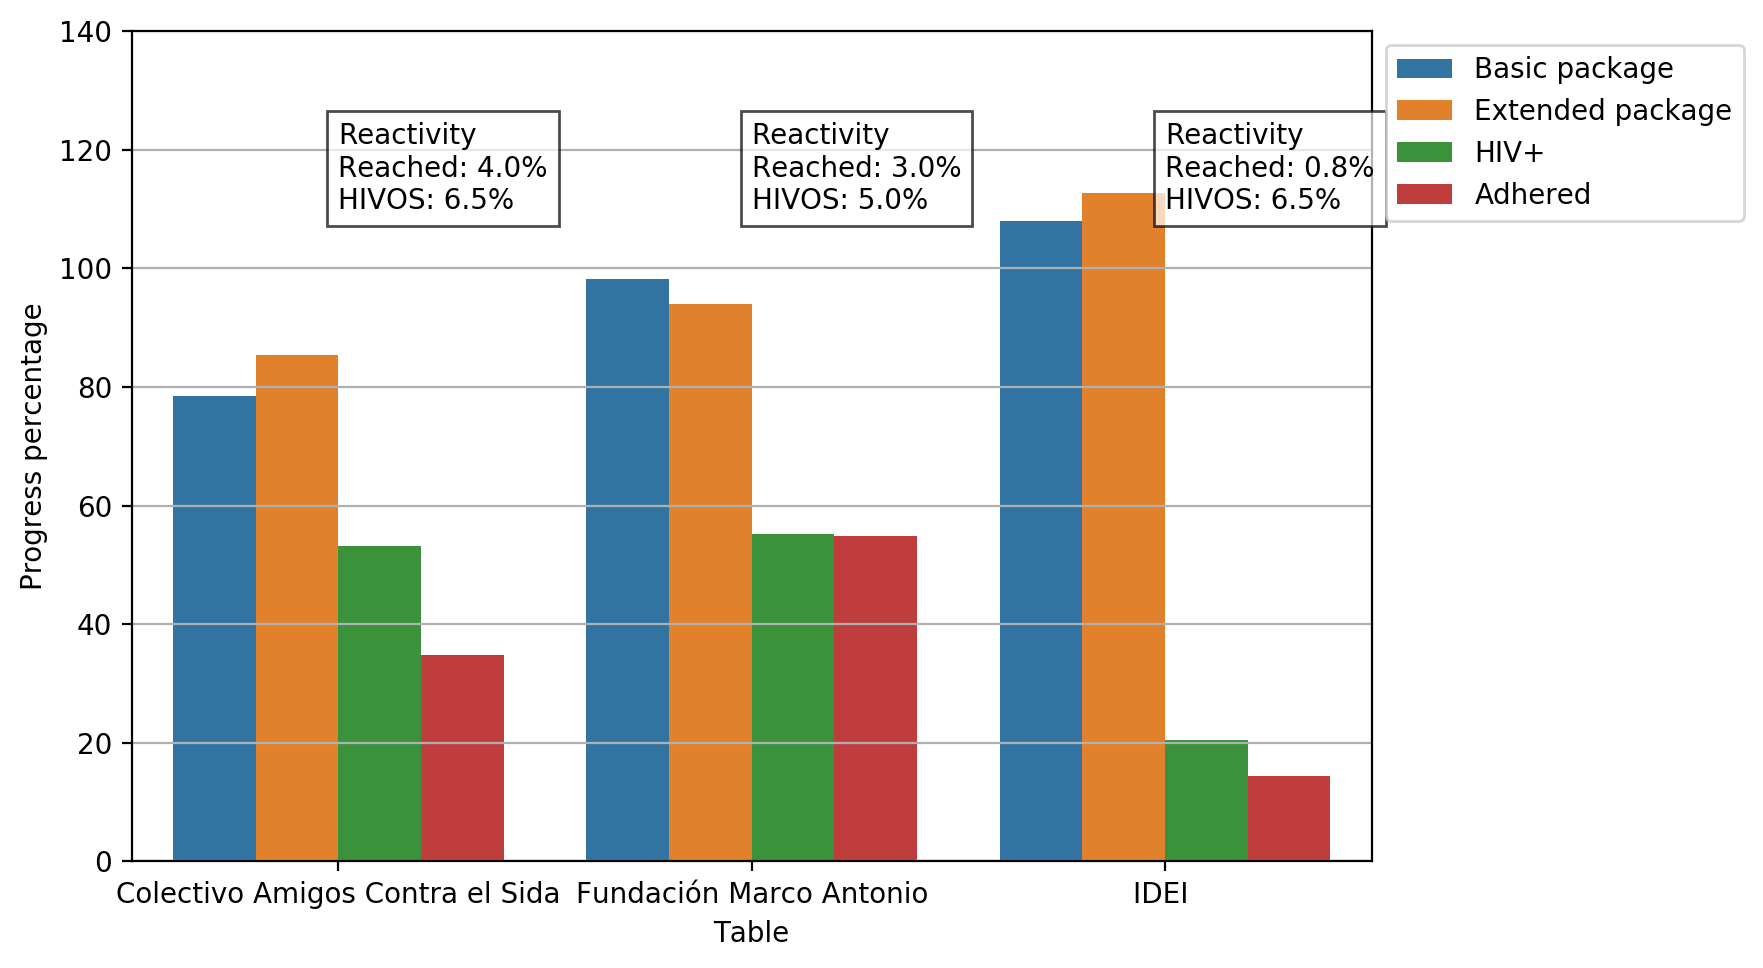

In [16]:
plt.rcParams["figure.figsize"] = (8,5.5)
plt.grid()
sb.barplot("Table", "Progress", "Goal", data)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("Progress percentage")
#plt.title("Subreceptors Progress with MSM Population Goals \n(Jan - Sep 2018)", fontsize=15)
plt.ylim(0,140)
i = 0
for key, values in reacts.items():
    plt.text(i, 110, "Reactivity\nReached: "+str(np.round(100*values[0],1))+"%\nHIVOS: "+str(np.round(100*values[1],1))+ "%", 
            bbox=dict(facecolor='white', alpha=0.7), horizontalalignment='left')
    i+=1

In [42]:
dfs = []
reacts = {}
for i in (2, 12, 23):
    title = sheet2.row_values(i)
    data = [sheet2.row_values(j) for j in range(i+1, i+5)]
    dfs.append(pd.DataFrame(data = {"Goal": [str.strip(j[0]).replace("P ", "P. ") for j in data], 
                                    "Progress": [j[13] for j in data], 
                                    "Table": [title[0]]*4}))
reacts["OTRANS"] = (sheet2.row_values(8)[1], sheet2.row_values(8)[4], sheet2.row_values(8)[8])
reacts["FUNDAMACO"] = (sheet2.row_values(18)[1], sheet2.row_values(18)[4], sheet2.row_values(18)[7])
reacts["IDEI"] = (sheet2.row_values(29)[1], sheet2.row_values(29)[4], sheet2.row_values(29)[7])
data = pd.concat(dfs, 0)
data = data.replace({"Goal": {
    "Positivos": "HIV+",
    "P. basico": "Basic package",
    "P. extendido": "Extended package",
    "Vinculados": "Adhered"
}})

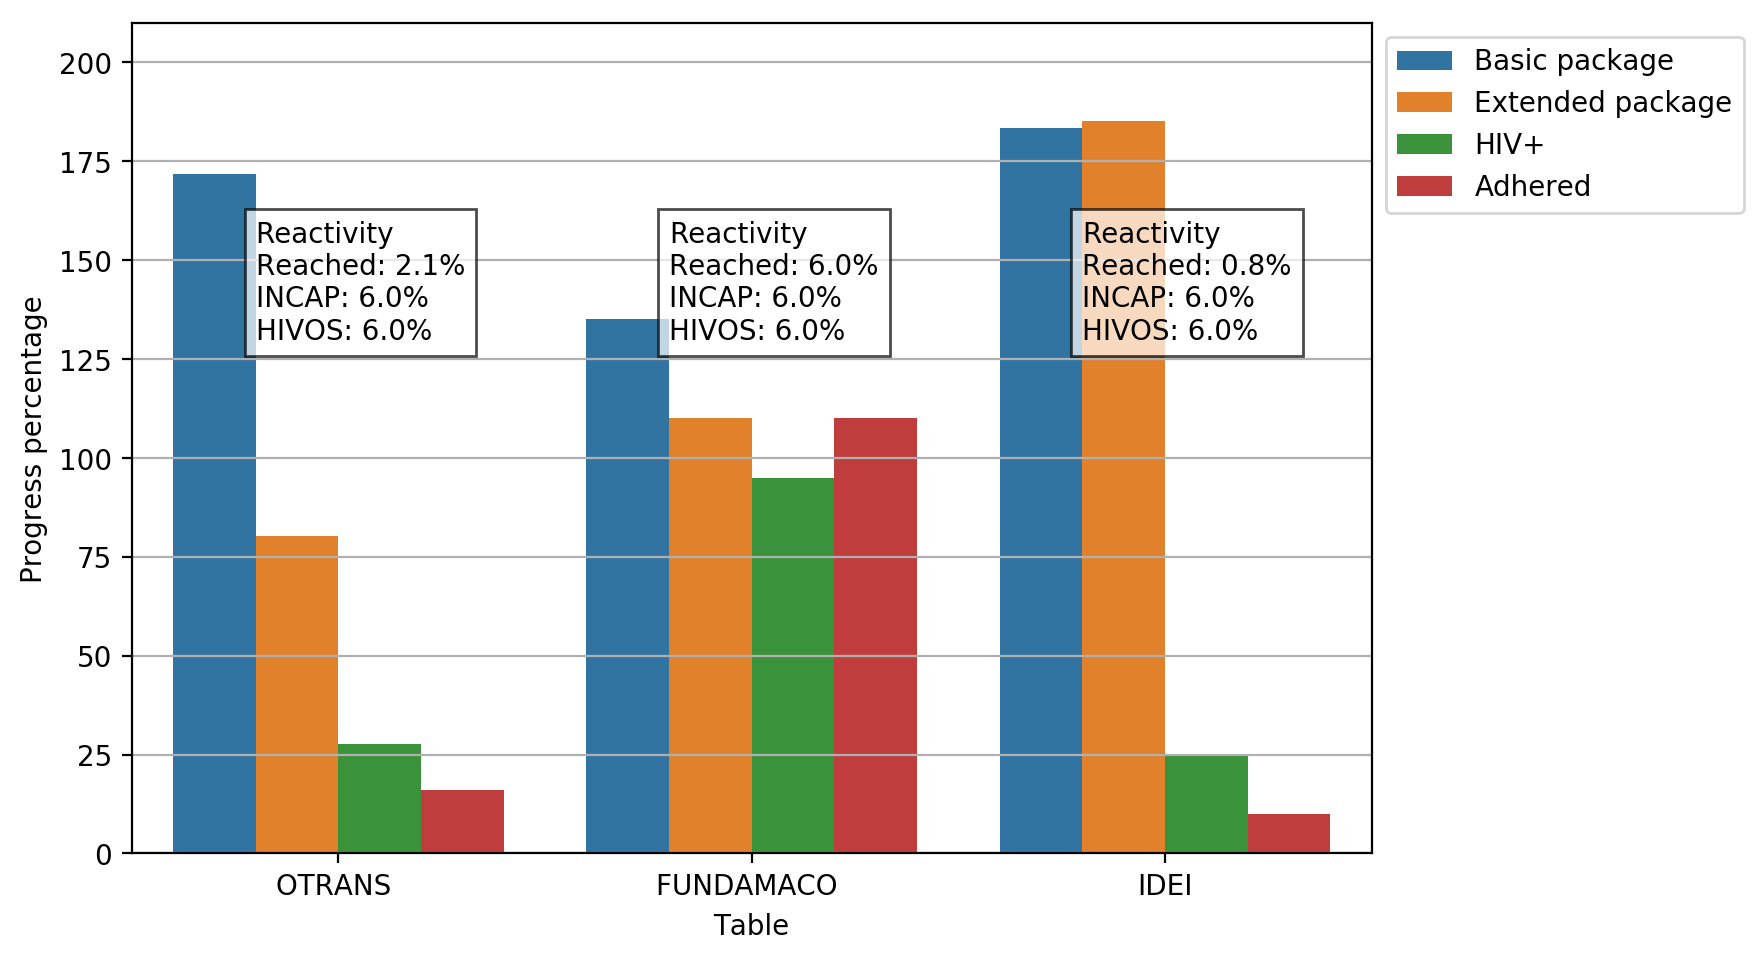

In [43]:
plt.rcParams["figure.figsize"] = (8,5.5)
plt.grid()
sb.barplot("Table", "Progress", "Goal", data)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("Progress percentage")
#plt.title("Subreceptors Progress with Trans Population Goals \n(Jan - Sep 2018)", fontsize=15)
plt.ylim(0,210)
i = 0
for key, values in reacts.items():
    plt.text(i-0.2, 130, "Reactivity\nReached: "+str(np.round(100*values[0],1))+"%\nINCAP: "+str(np.round(100*values[1],1))+ "%\nHIVOS: "+str(np.round(100*values[2],1))+ "%", 
            bbox=dict(facecolor='white', alpha=0.7), horizontalalignment='left')
    i+=1

# Personas que recibieron paquete básico

In [21]:
pb_tvc.columns

Index(['Unnamed: 0', 'numeroInforme', 'codigoActividad', 'codigounico',
       'codgrupo', 'codsubgrupo', 'refervih', 'prePruebaVIH', 'pruebaVIH',
       'postPruebaVIH', 'conoceResultadoVIH', 'codResultadoVIH',
       'conoceResultadoSif', 'codResultadoSif', 'condonesMasculinos',
       'condonesFemeninos', 'condonesSabores', 'lubriSachet', 'lubriTubo',
       'impresos', 'grupo', 'subgrupo', 'resultadoVIH', 'codejecutor',
       'codanno', 'codmes', 'codigoTipoActividad', 'tipoActividad',
       'resultadoSif', 'codDepMun', 'lugar', 'direccion', 'responsable',
       'educador', 'unmovil', 'fechareal', 'departamento', 'municipio', 'tema',
       'pqBasico', 'Date', 'Gender', 'Age', 'municode'],
      dtype='object')

In [26]:
len(pb_tvc.codigounico.unique()), len(pb_tvc)

(21783, 27840)

In [33]:
temp = pb_tvc[["codigounico", "Date"]].groupby("codigounico").Date.first().map(lambda x: x[0:7] if type(x) == str else "0").value_counts().sort_index()
temp

0            31
2018-01    1016
2018-02    1705
2018-03    1926
2018-04    2302
2018-05    2376
2018-06    1920
2018-07    2189
2018-08    2149
2018-09    1952
2018-10    2062
2018-11    2102
2018-12      38
2020-10      15
Name: Date, dtype: int64

In [34]:
pb_tvc.Date.map(lambda x: x[0:7] if type(x) == str else "0").value_counts().sort_index()

0            40
2018-01    1036
2018-02    1737
2018-03    2018
2018-04    2569
2018-05    2919
2018-06    2465
2018-07    2955
2018-08    2998
2018-09    2804
2018-10    3022
2018-11    3201
2018-12      58
2020-10      18
Name: Date, dtype: int64